# Programming Z3
by example

In [1]:
!pip install "z3-solver"
from z3 import *

     |████████████████████████████████| 19.1MB 7.6kB/s eta 0:00:01    |███▋                            | 2.2MB 1.3MB/s eta 0:00:13     |█████▌                          | 3.3MB 1.3MB/s eta 0:00:12     |█████████▍                      | 5.6MB 895kB/s eta 0:00:16��███▌          | 12.8MB 1.4MB/s eta 0:00:05


## Warmup
Formulas and Solvers

In [2]:
Z = IntSort()
B = BoolSort()
f = Function('f', B, Z)
g = Function('g', Z, B)
a = Bool('a')
solve(g(1+f(a)))


[a = False, f = [else -> 0], g = [else -> True]]


In [3]:
solve(And(g(1+f(a)), Not(g(2)), a))

[a = True, f = [else -> 0], g = [2 -> False, else -> True]]


In [4]:
solve(And(g(1+f(a)), Not(g(2)), a, f(True) == 1))

no solution


## SMT101

In [5]:
Z = IntSort()
f = Function('f', Z, Z)
x, y, z = Ints('x y z')
A = Array('A',Z,Z)
prove(Implies(x + 2 == y, f(Store(A, x, 3)[y - 2]) == f(y - x + 1)))

proved


## Quantifiers 102 - a sorted heap

* function _ref_ represents a pointer at an address. 

* function _deref_ dereferences pointers.

Properties:

* Values within a fixed range are sorted

* Pointer _p0_ that is not part of range

* Introduce heap _newH_ that is updated at position _p1_

* New heap _hewH_ is _not_ sorted

* Is it possible that _p0 = p1_ ?



In [6]:
Ptr = DeclareSort('Ptr')
ref = Function('ref', Z, Ptr)
deref = Function('deref', Ptr, Z)
n, x, x1, x2 = Ints('n x x1 x2')

# The following formula states that the values referenced by the
# pointers stored in ref at positions [0, n] are sorted.

s = Solver()
s.add(ForAll([x1,x2], Implies(And(0 <= x1, x1 <= x2, x2 <= n), deref(ref(x1)) <= deref(ref(x2)))))

p0 = Const('p0', Ptr)

# ref does not contain the pointer p0 in the interval [0, n].
s.add(ForAll(x, Implies(And(0 <= x, x <= n), ref(x) != p0)))

In [7]:
# newH is the new heap with position p1 containing value a.
# newH = deref[p1 <- a]
newH = Function('newH', Ptr, Z)
p, p1 = Consts('p p1', Ptr)
a = Const('a', Z)
s.add(newH(p1) == a)
s.add(ForAll(p, Or(p == p1, newH(p) == deref(p))))

# The new heap is not sorted
s.add(Not(ForAll([x1,x2], Implies(And(0 <= x1, x1 <= x2, x2 <= n), newH(ref(x1)) <= newH(ref(x2))))))

print(s.check())
print(s.model())

sat
[p0 = Ptr!val!2,
 a = -1,
 p1 = Ptr!val!0,
 n = 1,
 newH = [Ptr!val!0 -> -1,
         Ptr!val!1 -> 0,
         else -> deref(Var(0))],
 deref = [else -> 0],
 ref = [else ->
        If(If(1 <= Var(0), 1, 0) == 0,
           Ptr!val!1,
           If(If(1 <= Var(0), 1, 0) == 1,
              Ptr!val!0,
              Ptr!val!3))]]


In [8]:
s.add(p0 == p1)
print(s.check())

unsat


## Bounded Model Checking


* Checking modulo assumptions

* Expression manipulation by substitutions



In [9]:
def bmc(init, trans, goal, fvs0, x0s):
    xs = [fresh(0, x) for x in x0s]
    xns = [fresh(1, x) for x in x0s]
    fvs = fvs0
    s = Solver()
    s.add(init)
    p0 = Bool('p')
    count = 1
    while True:
        print("iteration ", count)
        count += 1
        p = fresh(count, p0)
        s.add(Implies(p, goal))
        if sat == s.check(p):
            return s.model()
        s.add(trans)
        ys = [fresh(count, x) for x in x0s]
        nfvs = [fresh(count, x) for x in fvs0]
        trans = substitute(trans, 
                           zipp(xns + xs + fvs, ys + xns + nfvs))
        goal = substitute(goal, zipp(xs, xns))
        xs, xns, fvs = xns, ys, nfvs




In [10]:

def fresh(round, x):
    s = x.sort()
    return Const("%s%d" % (x,round), s)

def zipp(xs, ys):
    return [p for p in zip(xs, ys)]


x, x0, x1 = Consts('x x0 x1', BitVecSort(4))
bmc(x0 == 0, x1 == x0 + 3, x0 == 10, [], [x])

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15


[x0 = 0,
 p7 = False,
 x11 = 1,
 x9 = 11,
 p3 = False,
 x2 = 6,
 p13 = False,
 p2 = False,
 p12 = False,
 x12 = 4,
 p8 = False,
 p5 = False,
 p10 = False,
 p14 = False,
 x13 = 7,
 x8 = 8,
 x14 = 10,
 x1 = 3,
 x6 = 2,
 x10 = 14,
 p6 = False,
 p16 = True,
 p4 = False,
 p9 = False,
 p11 = False,
 x3 = 9,
 p15 = False,
 x5 = 15,
 x4 = 12,
 x7 = 5]

## Encoding pebble games

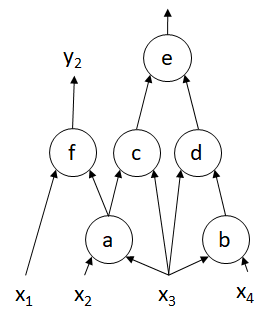

* Cardinality constraints

* Encoding the pebble transition relation


In [11]:
x, y, z, u, a,b,c,d,e,f = Bools('x y z u a b c d e f')
x0,y0,z0,u0,a0,b0,c0,d0,e0,f0 = Bools('x0 y0 z0 u0 a0 b0 c0 d0 e0 f0')
x1,y1,z1,u1,a1,b1,c1,d1,e1,f1 = Bools('x1 y1 z1 u1 a1 b1 c1 d1 e1 f1')


In [12]:


init = And([x0, y0, z0, u0, Not(a0), Not(b0), Not(c0), Not(d0), Not(e0), Not(f0)])

final = And([x0, y0, z0, u0, Not(a0), Not(b0), Not(c0), Not(d0), e0, f0])



* If the pebbling state changes on a node, then both children must be pebbled.

In [13]:
edges = [(x0,f0),(y0,a0),(z0,a0),(z0,c0),(z0,d0),(z0,b0),(u0,b0),(a0,f0),(a0,c0),(b0,d0),(d0,e0),(c0,e0)]

next = { x0 : x1, y0 : y1, z0 : z1, u0 : u1, a0 : a1, b0 : b1, c0 : c1, d0 : d1, e0 : e1, f0 : f1 }

add_pebble = [Implies(Xor(parent, next[parent]), And(child, next[child])) for (child, parent) in edges]

In [14]:
def transition(bound):
    max_pebbles = AtMost(x0,y0,z0,u0,a0,b0,c0,d0,e0,f0, bound)
    return And(add_pebble + [max_pebbles])

model = bmc(init, transition(5), final, [], [x, y, z, u, a, b, c, d, e, f])

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12


In [15]:
def display_model(m, vs):
    count = 0
    while True:
        xs = [fresh(count, x) for x in vs]
        if True in [x.decl() in m for x in xs]: 
            print([m[x] for x in xs])
            count += 1
        else:
            break
            
display_model(model, [x, y, z, u, a, b, c, d, e, f])

        

[True, True, True, True, False, False, False, False, False, False]
[False, True, True, True, True, True, False, False, False, False]
[False, True, True, False, True, True, True, False, False, False]
[False, True, True, False, False, True, True, True, False, False]
[False, False, True, False, False, True, True, True, True, False]
[False, False, True, True, False, True, True, False, True, False]
[False, True, True, True, False, False, True, False, True, False]
[False, True, True, False, True, False, True, False, True, False]
[True, False, True, False, True, False, False, False, True, False]
[True, False, True, False, True, False, False, False, True, True]
[False, True, True, False, True, False, False, False, True, True]
[True, True, True, True, False, False, False, False, True, True]


* Graphical representation for a larger example

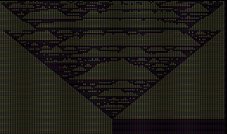

## As Horn Clauses

In [16]:
def horn_solver(init, transition, final, fvs0, xs):
    fp = SolverFor("HORN")
    Inv = Function('I', [x.sort() for x in xs] + [BoolSort()])
    xs0 = [fresh(0, x) for x in xs]
    xs1 = [fresh(1, x) for x in xs]
    fp.add(ForAll(xs0, Implies(init, Inv(xs0))))
    fp.add(ForAll(xs0+xs1+fvs0, Implies(And(Inv(xs0), transition), Inv(xs1))))
    fp.add(ForAll(xs0, Implies(Inv(xs0), Not(final))))
    #print(fp.sexpr())
    print(fp.check())
    print(fp.model())
    
horn_solver(init, transition(4), final,  [], [x, y, z, u, a, b, c, d, e, f])

sat
[I = [else -> Or(Not(Var(9)), Not(Var(8)), Var(7), Var(4))]]


## Fixedpoint solver

In [17]:
def horn_fp(init, transition, final, fvs0, xs, engine='spacer'):
    fp = Fixedpoint()
    Inv = Function('I', [x.sort() for x in xs] + [ BoolSort() ])    
    Q   = Function('Q', [x.sort() for x in xs] + [ BoolSort() ])
    fp.register_relation(Inv, Q)
    xs0 = [fresh(0, x) for x in xs]
    xs1 = [fresh(1, x) for x in xs]   
    fp.set(engine=engine)
    fp.declare_var(xs0 + xs1 + fvs0)
    fp.add_rule(Inv(xs0), init)
    fp.add_rule(Inv(xs1), And(Inv(xs0), transition)) 
    fp.add_rule(Q(xs0),   And(Inv(xs0), final))
    #print(fp)
    print(fp.query(Q))
    print(fp.get_answer())
    
horn_fp(init, transition(4), final, [], [x, y, z, u, a, b, c, d, e, f])

unsat
ForAll([A, B, C, D, E, F, G, H, K, L],
       I(A, B, C, D, E, F, G, H, K, L) ==
       Or(E, Not(L), Not(K), G))


In [18]:
horn_fp(init, transition(5), final, [], [x, y, z, u, a, b, c, d, e, f], 'bmc')

sat
hyper-res(hyper-res(hyper-res(hyper-res(hyper-res(hyper-res(hyper-res(hyper-res(hyper-res(hyper-res(hyper-res(hyper-res(asserted(Implies(I(True,
                                        True,
                                        True,
                                        True,
                                        False,
                                        False,
                                        False,
                                        False,
                                        True,
                                        True),
                                        query!44(True,
                                        True,
                                        False,
                                        False,
                                        False,
                                        False,
                                        True,
                                        True,
                                        True,
     

## Unweighted MaxSAT

MaxRes algorithm by Narodytska and Bacchus, AAAI 2014. 

* Unsat cores

Core based MaxSAT

* Relax every core _f1, f2, f3, f4, ..., f10_
* Into _g1, g2, g3, .., g9._
* Such that for every interpretation _M_
* Old model-string: _M(f1), M(f2), M(f3), M(f4), ... = 10100011_
* New model-string removes first 0: _M(g1), M(g2), M(g3), M(g4), ... = 1100011_


In [19]:
def tt(s, f):
    return is_true(s.model().eval(f))

def add_def(s, fml):
    name = Bool("%s" % fml)
    s.add(name == fml)
    return name

def relax_core(s, core, Fs):
    prefix = BoolVal(True)
    Fs -= { f for f in core }
    for i in range(len(core)-1):
        prefix = add_def(s, And(core[i], prefix))
        Fs |= { add_def(s, Or(prefix, core[i+1])) }

def maxsat(s, Fs):
    cost = 0
    Fs0 = Fs.copy()
    while unsat == s.check(Fs):
        cost += 1
        relax_core(s, s.unsat_core(), Fs)    
    return cost, { f for f in Fs0 if tt(s, f) }


In [20]:
a, b, c, d, e = Bools('a b c d e')
Fs = {a, Implies(a, b), Implies(b, c), Not(c)}
s = Solver()
maxsat(s, Fs)

(1, {Implies(b, c), Not(c), a})

In [21]:
a, b, c, d, e = Bools('a b c d e')
Fs = {a, Implies(a, b), Implies(b, c), Not(c)}
s = Solver()
s.add(c)
maxsat(s, Fs)

(1, {Implies(a, b), Implies(b, c), a})

## Built-in optimizer

In [22]:
opt = Optimize()
opt.add_soft(a)
opt.add_soft(Implies(a, b))
opt.add_soft(Not(b))
opt.add(c)
print(opt.check())
print(opt.model())

# print(opt)

sat
[a = True, b = False, c = True]


## RC2

* weighted MaxSAT
* cardinality constraints
* using Quantifier-free finite domain solver


In [23]:

def tt(s, f):
    return is_true(s.model().eval(f))

def add(Ws, f, w):
    Ws[f] = w + (Ws[f] if f in Ws else 0)

def sub(Ws, f, w):
    w1 = Ws[f]
    if w1 > w:
        Ws[f] = w1 - w
    else:
        del(Ws[f])

class RC2:

    def __init__(self, s):
        self.bounds = {}
        self.names = {}
        self.solver = s
        self.solver.set("sat.cardinality.solver", True)
        self.solver.set("sat.core.minimize", True)
        self.solver.set("sat.core.minimize_partial", True)
        
    def at_most(self, S, k):
        fml = simplify(AtMost(S + [k]))
        if fml in self.names:
           return self.names[fml]
        name = Bool("%s" % fml)
        self.solver.add(Implies(name, fml))
        self.bounds[name] = (S, k)
        self.names[fml] = name
        return name

    def print_cost(self):
        print("cost [", self.min_cost, ":", self.max_cost, "]")

    def update_max_cost(self):
        self.max_cost = min(self.max_cost, self.get_cost())
        self.print_cost()
    
    # sort W, and incrementally add elements of W
    # in sorted order to prefer cores with high weight.
    def check(self, Ws):
        def compare(fw):
            f, w = fw
            return -w
        ws = sorted([(k,Ws[k]) for k in Ws], key = compare)
        print(ws)
        i = 0
        while i < len(ws):
           j = i
           # increment j until making 5% progress or exhausting equal weight entries
           while (j < len(ws) and ws[j][1] == ws[i][1]) or (i > 0 and (j - i)*20 < len(ws)):
              j += 1
           i = j
           r = self.solver.check([ws[j][0] for j in range(i)])
           if r == sat:
              self.update_max_cost()
           else:
              return r
        return sat
             
    def get_cost(self):
        return sum(self.Ws0[c] for c in self.Ws0 if not tt(self.solver, c))

    # Retrieve independendent cores from Ws
    def get_cores(self, Ws):
        cores = []
        while unsat == self.check(Ws):            
            core = list(self.solver.unsat_core())
            print (self.solver.statistics())
            if not core:
               return unsat
            w = min([Ws[c] for c in core])
            for f in core:
                sub(Ws, f, w)
            cores += [(core, w)]
        self.update_max_cost()
        return cores
           
    # Add new soft constraints to replace core
    # with weight w. Allow to weaken at most
    # one element of core. Elements that are
    # cardinality constraints are weakened by
    # increasing their bounds. Non-cardinality
    # constraints are weakened to "true". They
    # correspond to the constraint Not(s) <= 0, 
    # so weakening produces Not(s) <= 1, which
    # is a tautology.
    def update_bounds(self, Ws, core, w):
        for f in core:
           if f in self.bounds:
              S, k = self.bounds[f]
              if k + 1 < len(S):
                 add(Ws, self.at_most(S, k + 1), w)                
        add(Ws, self.at_most([mk_not(f) for f in core], 1), w)

    # Ws are weighted soft constraints
    # Whenever there is an unsatisfiable core over ws
    # increase the limit of each soft constraint from a bound
    # and create a soft constraint that limits the number of
    # increased bounds to be at most one.
    def maxsat(self, Ws):
        self.min_cost = 0
        self.max_cost = sum(Ws[c] for c in Ws)
        self.Ws0 = Ws.copy()
        while True:
            cores = self.get_cores(Ws)
            if not cores:
                break
            if cores == unsat:
               return unsat
            for (core, w) in cores:
               self.min_cost += w
               self.print_cost()
               self.update_bounds(Ws, core, w)            
        return self.min_cost, { f for f in self.Ws0 if not tt(self.solver, f) }

    def from_file(self, file):
        opt = Optimize()
        opt.from_file(file)
        self.solver.add(opt.assertions())
        obj = opt.objectives()[0]
        Ws = {}        
        for f in obj.children():
            assert(f.arg(1).as_long() == 0)
            add(Ws, f.arg(0), f.arg(2).as_long())
        return self.maxsat(Ws)
    
    def from_formulas(self, hard, soft):      
        self.solver.add(hard)
        Ws = {}        
        for f, cost in soft:
            add(Ws, f, cost)
        return self.maxsat(Ws)



In [24]:
a, b, c, d, e = Bools('a b c d e')
Fs = [(a, 1), (Implies(a, b), 1), (Implies(b, c), 3), (Not(c), 4)]
RC = RC2(SolverFor("QF_FD"))
soln = RC.from_formulas(True, Fs)
print(soln)

[(Not(c), 4), (Implies(b, c), 3), (Implies(a, b), 1), (a, 1)]
cost [ 0 : 5 ]
cost [ 0 : 2 ]
(:max-memory            7.27
 :memory                4.28
 :num-allocs            150828412
 :rlimit-count          121670
 :sat-conflicts         1
 :sat-mk-clause-2ary    12
 :sat-mk-clause-3ary    3
 :sat-mk-var            9
 :sat-propagations-2ary 18
 :sat-propagations-3ary 7)
[(Not(c), 3), (Implies(b, c), 2)]
cost [ 0 : 1 ]
cost [ 0 : 1 ]
cost [ 0 : 1 ]
cost [ 1 : 1 ]
[(Not(c), 3), (Implies(b, c), 2), (at-least(a, Or(Not(a), b), Not(c), Or(Not(b), c)), 1)]
cost [ 1 : 1 ]
cost [ 1 : 1 ]
cost [ 1 : 1 ]
cost [ 1 : 1 ]
(1, {a})


## AllSMT with prime implicants

* Create two solvers, _primal_, _dual_
* Extract solution from _primal_
* Minimize implicant using _dual_

In [25]:
def all_sat(atoms, fmls):
    primal = Solver()
    dual   = Solver()
    primal.add(fmls)
    dual.add(Not(And(fmls)))
    while True:
        is_sat = primal.check()
        if sat == is_sat:
            m = primal.model()            
            lits = [mk_lit(m, a) for a in atoms]
            is_sat = dual.check(lits)
            if is_sat == unsat:
                core = dual.unsat_core()
            else:
                core = lits
            print(core)
            primal.add(Not(And(core)))
        else:
            print(is_sat)
            return

def mk_lit(m, p):
    if is_true(m.eval(p)):
        return p
    else:
        return Not(p)

In [26]:
a, b, c = Bools('a b c')
x, y = Reals('x y')
fml = [If(a, And(0 <= y, y <= 2), And(1 <= y, y <= 3)),
       If(b, And(2 <= y, y <= 5), And(-3 <= y, y <= 0)),
       Or(x + y < 3, x - y > 2),
       x >= 0,
       Or(c, Not(c)),
       1 >= x]
all_sat([a, b, c], fml)

[a, Not(b), Not(c)]
[Not(a), b, Not(c)]
[Not(a), b, c]
[a, Not(b), c]
[a, b, Not(c)]
[a, b, c]
unsat


Minimizing min-terms

In [27]:
def all_smt(atoms0, fml):
    fml = And(fml)
    primal   = Solver()
    dual   = Solver()
    atoms1 = set(atoms0)
    seen = set([])
    get_atoms(atoms1, seen, fml)
    print("Atoms:", atoms1)
    primal.add(fml)
    dual.add(Not(fml))
    while True:
        is_sat = primal.check()
        if sat == is_sat:
            m = primal.model()   
            lits = [mk_lit(m, p) for p in atoms1]
            is_sat = dual.check(lits)
            assert(is_sat == unsat)
            core = dual.unsat_core()
            core = [c for c in core if c in atoms0]
            print("Model", m, "core:", core)
            primal.add(Not(And(core)))
        else:
            print(is_sat)
            return


In [28]:
def get_atoms(atoms, seen, term):    
    if term in seen:
        return
    seen |= { term }
    args = term.children()
    if is_bool(term) and len([ch for ch in args if not is_bool(ch)]) > 0:
        atoms |= { term }
    for f in args:
        get_atoms(atoms, seen, f) 

def mk_lit(m, p):
    if is_true(m.eval(p)):
        return p
    else:
        return Not(p)

In [29]:
a, b, c = Bools('a b c')
x, y = Reals('x y')
fml = [If(a, And(0 <= y, y <= 2), And(1 <= y, y <= 3)),
       If(b, And(2 <= y, y <= 5), And(-3 <= y, y <= 0)),
       Or(x + y < 3, x - y > 2),
       x >= 0,
       Or(c, Not(c)),
       1 >= x]
all_smt([a, b, c], fml)

Atoms: {y >= 1, y >= 2, y >= -3, x - y > 2, y <= 2, y >= 0, x >= 0, b, a, y <= 5, x <= 1, y <= 0, x + y < 3, c, y <= 3}
Model [b = False, a = True, y = 0, x = 0] core: [a]
Model [b = True, a = False, y = 2, x = 0] core: [b]
unsat


## Cubing

* Decimate problems into independent sub-problems

In [30]:
s = SolverFor("QF_FD")
s.from_file("core.cnf")
s.set("lookahead.cube.depth", 3)
for c in s.cube():
    print(c)

[k!8457, Not(k!8296), k!8746]
[k!8457, Not(k!8296), Not(k!8746)]
[k!8457, k!8296, k!642]
[k!8457, k!8296, Not(k!642)]
[Not(k!8457), Not(k!8571), k!1753]
[Not(k!8457), Not(k!8571), Not(k!1753)]
[Not(k!8457), k!8571, Not(k!4670)]
[Not(k!8457), k!8571, k!4670]
